<a href="https://colab.research.google.com/github/stellazhangsy/Covid19Challenge/blob/master/COVID19_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Challenge:  Who's still hiring?

**Group Member: Vannesa Leung/Minke Wang/Yuping Qi/Stella Zhang**



## Install & Import Packages

In [0]:
# !pip install -q kaggle
# ! apt-get install default-jre
# !java -version
! pip install h2o
# data preprocessing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#machine learning package
import h2o
#file handling
import os
from google.colab import files

     |████████████████████████████████| 129.5MB 83kB/s 
  Created wheel for h2o: filename=h2o-3.30.0.1-py2.py3-none-any.whl size=129557718 sha256=7d6e41957838ae83ccbcb126c563f70b3d3d956825aa948d5419bb43856a5eff
  Stored in directory: /root/.cache/pip/wheels/db/42/63/d118d7218432054da842f5d10bd4f99e978bde0931164e6c7a
Successfully built h2o


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Import Dataset from Multiple Sources

In [0]:
# import the candor dataset of company hiring status
data=pd.read_csv("https://raw.githubusercontent.com/vanessaaleung/rawdata/master/updated_apr_10.csv")

In [0]:
data.shape

(6267, 25)

In [0]:
data.head()

Company name  ... Hub Tags
0                GBKSOFT  ...      NaN
1  1A- Product Ventures   ...      NaN
2              1Password  ...      NaN
3                1stdibs  ...      NaN
4                  1sts   ...      NaN

[5 rows x 25 columns]

In [0]:
# import crunchbase company dataset of funding status
os.environ['KAGGLE_USERNAME'] = "minkewang" # username
os.environ['KAGGLE_KEY'] = "4ac64942fb1cdf679a628708e3cae405" # key
!kaggle datasets download -d arindam235/startup-investments-crunchbase # api copied from kaggle
cbdata = pd.read_csv('startup-investments-crunchbase.zip', compression='zip', header=0, sep=',', quotechar='"',thousands=r',',encoding= 'unicode_escape')

  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 81.1MB/s]


## Data Preprocessing

In [0]:
# clear unncessary strings within the dataset
cbdata['name']=cbdata['name'].str.strip()

In [0]:
# merge data from multiple sources
merge=pd.merge(cbdata,data,how='inner',left_on="name",right_on='Company name')

In [0]:
merge.sample(5)

permalink  ... Hub Tags
636                  /organization/smule  ...      NaN
336                  /organization/hinge  ...      NaN
757  /organization/vanderbilt-university  ...      NaN
221      /organization/dollar-shave-club  ...      NaN
139                  /organization/cisco  ...      NaN

[5 rows x 64 columns]

In [0]:
# convert string data to numerical 
merge[' funding_total_usd ']=merge[' funding_total_usd '].str.replace(',', '').str.replace('-', '0').str.replace(' ', '').astype(float)

In [0]:
# convert hiring status, hiring=1, hiring freeze/layoffs=0; y variable
merge['HiringStatus']=(merge['Status'].isin(['Hiring'])).astype(int)

In [0]:
##calculating new metric: company age
merge['company_age']=2020-merge['founded_year']

In [0]:
merge[merge['name']=='Xerox']

permalink   name  ... HiringStatus company_age
798  /organization/xerox  Xerox  ...            0       114.0

[1 rows x 66 columns]

In [0]:
merge[['Status','HiringStatus']]

Status  HiringStatus
0            Hiring             1
1    Hiring  freeze             0
2    Hiring  freeze             0
3    Hiring  freeze             0
4    Hiring  freeze             0
..              ...           ...
829          Hiring             1
830          Hiring             1
831          Hiring             1
832          Hiring             1
833          Hiring             1

[834 rows x 2 columns]

In [0]:
# drop unnecessary columns
drop_col=['permalink','homepage_url', 'category_list','country_code', 'state_code', 'region',
       'city','founded_at', 'founded_month',
       'founded_quarter', 'founded_year', 'first_funding_at',
       'last_funding_at','equity_crowdfunding','Company name', 'Notes', 'Status', 'Last modified', 'Where to apply',
       'Industry', 'Location', 'Founded Date', 'Founders', 'Funding Status',
       'Last Funding Type', 'Number of Employees', 'Revenue Range', 'Hug Tags',
       'Ipo Status', 'Company Type', 'Number of Acquisitions', 'Total Funding',
       'Headquarters Location', 'Headquarters Regions',
       'Number of Investments', 'Estimated Revenue Range', 'IPO Status',
       'Total Funding Amount', 'Hub Tags']
merge=merge.drop(columns=drop_col)

In [0]:
merge.head()

name          market   ...  HiringStatus company_age
0  1010data        Software   ...             1        20.0
1    15Five        Software   ...             0         9.0
2   1stdibs      E-Commerce   ...             0        19.0
3   23andMe   Biotechnology   ...             0        14.0
4        2U        Software   ...             0        12.0

[5 rows x 27 columns]

In [0]:
merge.HiringStatus.value_counts()

0    459
1    375
Name: HiringStatus, dtype: int64

In [0]:
# # connect to drive for output
# from google.colab import (drive, files)
# drive.mount('/content/gdrive', force_remount=True)
# path = "/content/gdrive"
# os.chdir(path)

In [0]:
#merge.to_csv('My Drive/Colab Notebooks/COVID19.csv')

In [0]:
#check companies with recent large scale layoffs
merge[merge['name']=='Yelp']

name             market   ...  HiringStatus company_age
800  Yelp   Customer Service   ...             0        16.0

[1 rows x 27 columns]

In [0]:
merge[merge['name']=='Thumbtack']

name        market   ...  HiringStatus company_age
709  Thumbtack   Curated Web   ...             0        12.0

[1 rows x 27 columns]

In [0]:
#merge=merge.drop(columns=['name','status'])

## Exploratory Data Analysis

In [0]:
df=merge.copy()

In [0]:
round_avg = pd.DataFrame(df.groupby(by=["HiringStatus"])[["round_A", "round_B", "round_C", "round_D"]].mean().reset_index())
round_avg = pd.melt(round_avg, id_vars=['HiringStatus'], value_vars=["round_A", "round_B", "round_C", "round_D"], value_name="avg funding", var_name="round")

Text(0.5, 1.0, 'Average funding and rounds by hiring status')

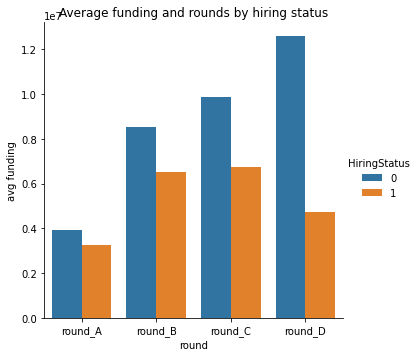

In [0]:
## hiring status and company funding rounds
sns.catplot(x="round", 
            y="avg funding", 
            hue="HiringStatus", 
            kind="bar", 
            data=round_avg,
            );
plt.title('Average funding and rounds by hiring status')

In [0]:
top_indsutries=pd.DataFrame(df[' market '].value_counts()>10)[:15].index
df[df[' market '].isin(top_indsutries)]

name          market   ...  HiringStatus company_age
0    1010data        Software   ...             1        20.0
1      15Five        Software   ...             0         9.0
2     1stdibs      E-Commerce   ...             0        19.0
3     23andMe   Biotechnology   ...             0        14.0
4          2U        Software   ...             0        12.0
..        ...              ...  ...           ...         ...
823      Zola      E-Commerce   ...             0         7.0
824     Zones      E-Commerce   ...             0        32.0
828      Zopa         Finance   ...             1        15.0
832  Zymergen   Biotechnology   ...             1         7.0
833     Zynga      Technology   ...             1        13.0

[381 rows x 27 columns]

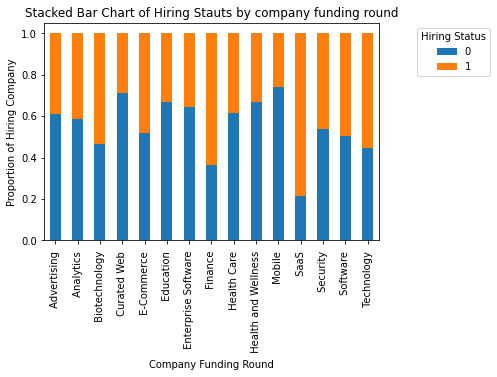

In [0]:
# explore the industry pattern towards hiring status
table=pd.crosstab(df[df[' market '].isin(top_indsutries)][' market '],df[df[' market '].isin(top_indsutries)].HiringStatus)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Hiring Stauts by company industry')
plt.xlabel('Company indsury')
plt.ylabel('Proportion of Hiring Company')
plt.legend(title='Hiring Status',bbox_to_anchor=(1.1, 1))

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([389., 210.,  81.,  30.,   9.,  12.,   6.,   3.,   4.,   4.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.]),
 array([  6.  ,  11.55,  17.1 ,  22.65,  28.2 ,  33.75,  39.3 ,  44.85,
         50.4 ,  55.95,  61.5 ,  67.05,  72.6 ,  78.15,  83.7 ,  89.25,
         94.8 , 100.35, 105.9 , 111.45, 117.  ]),
 <a list of 20 Patch objects>)

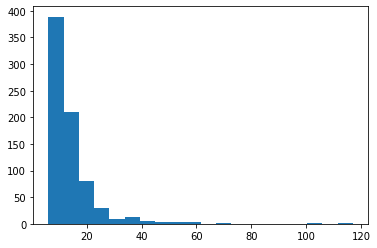

In [0]:
plt.hist(merge['company_age'],bins=20)

Text(0.5, 1.0, 'funding rounds and hiring status')

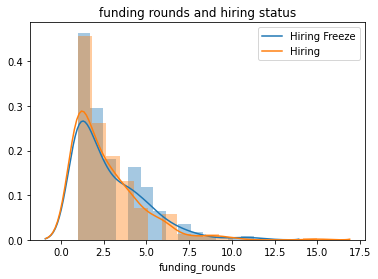

In [0]:
# explore the funding rounds 
bins = [0, 5, 10, 15]
funding_rounds_count = pd.DataFrame(df.groupby(['HiringStatus', pd.cut(df.funding_rounds, bins)]).size()).reset_index().rename(columns={0: "count"})
funding_rounds_count["percentage"] = funding_rounds_count["count"] 
for idx, row in funding_rounds_count.iterrows():
  hiring_status = row["HiringStatus"]
  sums = funding_rounds_count[funding_rounds_count["HiringStatus"] == hiring_status]["count"].sum()
  funding_rounds_count.loc[idx, "percentage"]  = row["count"] / sums
sns.distplot(df[df["HiringStatus"] == 0]["funding_rounds"], kde_kws={"label": "Hiring Freeze"})
sns.distplot(df[df["HiringStatus"] == 1]["funding_rounds"], kde_kws={"label": "Hiring"})
plt.title('Funding rounds and hiring status')

Text(0.5, 1.0, 'Company age and hiring status')

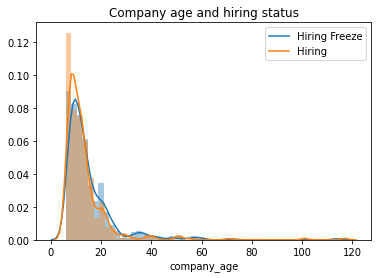

In [0]:
#company establish years vs hiring status
bins = [0, 5, 10, 15]
age = pd.DataFrame(df.groupby(['HiringStatus', pd.cut(df['company_age'], bins)]).size()).reset_index().rename(columns={0: "count"})
age["percentage"] = age["count"] 
for idx, row in age.iterrows():
  hiring_status = row["HiringStatus"]
  sums = age[age["HiringStatus"] == hiring_status]["count"].sum()
  age.loc[idx, "percentage"]  = row["count"] / sums
sns.distplot(df[df["HiringStatus"] == 0]["company_age"], kde_kws={"label": "Hiring Freeze"})
sns.distplot(df[df["HiringStatus"] == 1]["company_age"], kde_kws={"label": "Hiring"})
plt.title('Company age and hiring status')

## H2O AutoML
H2O’s AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit.

In [0]:
##initialize environment
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzp6cmgaj
  JVM stdout: /tmp/tmpzp6cmgaj/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpzp6cmgaj/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.0.1
H2O_cluster_version_age:    11 days
H2O_cluster_name:           H2O_from_python_unknownUser_dhmk5w
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.180 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.6.9 final
--------------------------  ------------------------------------------------------------------

In [0]:
# convert data to H2O data frame
merge_h2o=h2o.H2OFrame(merge)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
merge_h2o.shape

(834, 27)

In [0]:
merge_h2o.types

{' funding_total_usd ': 'int',
 ' market ': 'enum',
 'HiringStatus': 'int',
 'angel': 'int',
 'company_age': 'int',
 'convertible_note': 'int',
 'debt_financing': 'int',
 'funding_rounds': 'int',
 'grant': 'int',
 'name': 'string',
 'post_ipo_debt': 'int',
 'post_ipo_equity': 'int',
 'private_equity': 'int',
 'product_crowdfunding': 'int',
 'round_A': 'int',
 'round_B': 'int',
 'round_C': 'int',
 'round_D': 'int',
 'round_E': 'int',
 'round_F': 'int',
 'round_G': 'int',
 'round_H': 'int',
 'secondary_market': 'int',
 'seed': 'int',
 'status': 'enum',
 'undisclosed': 'int',
 'venture': 'int'}

In [0]:
#split train test dataset using h2o train split
train,test,valid = merge_h2o.split_frame(ratios=[.7, .15])

In [0]:
# define X and y variables 
y = 'HiringStatus'
x = train.columns
x.remove(y)
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [0]:
#auto machine learning package to predict results
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models=10, 
                balance_classes = True,
                max_runtime_secs=300, 
                seed = 1234,
                )
aml.train(x = x, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [0]:
aml.leaderboard

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 GBM_4_AutoML_20200415_083036 0.543452 0.842174 0.495204 0.494654 0.541316 0.293023 
 GBM_2_AutoML_20200415_083036 0.531138 0.879555 0.494613 0.495926 0.55139 0.304031 
 GBM_5_AutoML_20200415_083036 0.527234 0.814816 0.475408 0.5 0.536464 0.287794 
 XGBoost_3_AutoML_20200415_083036 0.521696 0.793185 0.46881 0.5 0.534734 0.28594 
 GBM_3_AutoML_20200415_083036 0.515755 0.941277 0.479228 0.5 0.569341 0.32415 
 DRF_1_AutoML_20200415_083036 0.515176 0.820841 0.482865 0.5 0.541751 0.293494 
 StackedEnsemble_BestOfFamily_AutoML_20200415_083036 0.51137 0.691973 0.472515 0.5 0.499393 0.249393 
 GBM_1_AutoML_20200415_083036 0.507274 0.913711 0.468914 0.493381 0.566748 0.321203 
 StackedEnsemble_AllModels_AutoML_20200415_083036 0.503697 0.692856 0.464693 0.5 0.499834 0.249834 
 GLM_1_AutoML_20200415_083036 0.502266 0.690052 0.449594 0.496942 0.498474 0.248476

In [0]:
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_4_AutoML_20200415_083036


Model Summary: 


number_of_trees  ...  max_leaves  mean_leaves
0               30.0  ...        42.0         34.3

[1 rows x 10 columns]



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07792947766752131
RMSE: 0.2791585170965079
LogLoss: 0.2858035390720864
Mean Per-Class Error: 0.05483736447039189
AUC: 0.9851959966638867
AUCPR: 0.9844986275978437
Gini: 0.9703919933277734

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4559483812604928: 


0      1   Error           Rate
0      0  301.0   26.0  0.0795   (26.0/327.0)
1      1   10.0  320.0  0.0303   (10.0/330.0)
2  Total  311.0  346.0  0.0548   (36.0/657.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.455948    0.946746  209.0
1                        max f2   0.450854    0.961654  212.0
2                  max f0point5   0.513085    0.946276  193.0
3                  max accuracy   0.484137    0.945205  202.0
4                 max precision   0.952755    1.000000    0.0
5                    max recall   0.334423    1.000000  253.0
6               max specificity   0.952755    1.000000    0.0
7              max absolute_mcc   0.455948    0.891443  209.0
8    max min_per_class_accuracy   0.497719    0.941896  196.0
9   max mean_per_class_accuracy   0.484137    0.945163  202.0
10                      max tns   0.952755  327.000000    0.0
11                      max fns   0.952755  329.000000    0.0
12                      max fps   0.025285  327.000000  399.0
13                      max tps   0.334423  330.000000  253.0
14                      max tnr   0.952755    1.000000    0.0
15                      max fnr   0.952755    0.996970    0.0
16                      max fpr   0.025285    1.000000  399.0
17                      max tpr   0.334423    1.000000  253.0


Gains/Lift Table: Avg response rate: 50.23 %, avg score: 47.90 %


group  ...        gain  cumulative_gain
0         1  ...   99.090909        99.090909
1         2  ...   99.090909        99.090909
2         3  ...   99.090909        99.090909
3         4  ...   99.090909        99.090909
4         5  ...   99.090909        99.090909
5         6  ...   99.090909        99.090909
6         7  ...   99.090909        99.090909
7         8  ...   99.090909        99.090909
8         9  ...   92.965035        97.069682
9        10  ...   90.041322        95.305911
10       11  ...   56.859504        87.593258
11       12  ...  -47.930070        65.235348
12       13  ...  -90.950413        42.826087
13       14  ... -100.000000        25.142857
14       15  ... -100.000000        11.167513
15       16  ... -100.000000         0.000000

[16 rows x 14 columns]



ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.29302304448417876
RMSE: 0.5413160301378288
LogLoss: 0.8421741159347108
Mean Per-Class Error: 0.4560452162516382
AUC: 0.5434523809523809
AUCPR: 0.49520374724833727
Gini: 0.08690476190476182

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.042358505038721087: 


0      1   Error            Rate
0      0   7.0  320.0  0.9786   (320.0/327.0)
1      1   3.0  277.0  0.0107     (3.0/280.0)
2  Total  10.0  597.0  0.5321   (323.0/607.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.042359    0.631699  390.0
1                        max f2   0.020824    0.810654  399.0
2                  max f0point5   0.155116    0.528261  338.0
3                  max accuracy   0.892048    0.551895   31.0
4                 max precision   0.957026    1.000000    0.0
5                    max recall   0.020824    1.000000  399.0
6               max specificity   0.957026    1.000000    0.0
7              max absolute_mcc   0.321955    0.094917  277.0
8    max min_per_class_accuracy   0.461337    0.525994  203.0
9   max mean_per_class_accuracy   0.321955    0.543955  277.0
10                      max tns   0.957026  327.000000    0.0
11                      max fns   0.957026  279.000000    0.0
12                      max fps   0.024972  327.000000  398.0
13                      max tps   0.020824  280.000000  399.0
14                      max tnr   0.957026    1.000000    0.0
15                      max fnr   0.957026    0.996429    0.0
16                      max fpr   0.024972    1.000000  398.0
17                      max tpr   0.020824    1.000000  399.0


Gains/Lift Table: Avg response rate: 46.13 %, avg score: 44.81 %


group  ...       gain  cumulative_gain
0         1  ...  23.877551        23.877551
1         2  ... -27.738095         0.054945
2         3  ... -27.738095        -8.721805
3         4  ...  80.654762        12.728571
4         5  ...  44.523810        18.882488
5         6  ...   8.392857        13.723653
6         7  ...   1.166667         9.583987
7         8  ...  -2.096774         6.615925
8         9  ...  12.005952         8.392857
9        10  ...  10.169789         8.838918
10       11  ...  -4.045667         6.253524
11       12  ...  -6.059524         4.223901
12       13  ...  20.831382         6.607563
13       14  ... -27.738095         2.358616
14       15  ...   3.062061         2.437206
15       16  ... -21.814988         0.000000

[16 rows x 14 columns]



Cross-Validation Metrics Summary: 


mean  ...   cv_4_valid    cv_5_valid
0                  accuracy  0.49581358  ...    0.5041322     0.4876033
1                       auc   0.5474711  ...   0.52021855     0.6186813
2                     aucpr   0.5190139  ...   0.49464008     0.6169765
3                       err  0.50418645  ...   0.49586776     0.5123967
4                 err_count        61.2  ...         60.0          62.0
5                  f0point5   0.5322422  ...     0.559633    0.52884614
6                        f1  0.64289194  ...    0.6703297     0.6395349
7                        f2  0.81213635  ...    0.8356164     0.8088235
8            lift_top_group   1.5379273  ...          0.0     2.1607144
9                   logloss  0.84212995  ...   0.94648874    0.74066377
10      max_per_class_error  0.92488986  ...          1.0    0.93846154
11                      mcc   0.1556029  ...          NaN      0.109429
12  mean_per_class_accuracy   0.5304749  ...          0.5    0.52184063
13     mean_per_class_error  0.46952513  ...          0.5    0.47815934
14                      mse  0.29299417  ...   0.31949827     0.2544656
15                   pr_auc   0.5190139  ...   0.49464008     0.6169765
16                precision   0.4775131  ...    0.5041322    0.47413793
17                       r2  -0.1828626  ...  -0.27808034  -0.023524974
18                   recall   0.9858396  ...          1.0    0.98214287
19                     rmse  0.54036987  ...   0.56524175    0.50444585

[20 rows x 8 columns]


See the whole table with table.as_data_frame()

Scoring History: 


timestamp  ... training_lift  training_classification_error
0    2020-04-15 08:31:00  ...      1.000000                       0.497717
1    2020-04-15 08:31:00  ...      1.990909                       0.124810
2    2020-04-15 08:31:00  ...      1.990909                       0.115677
3    2020-04-15 08:31:01  ...      1.990909                       0.100457
4    2020-04-15 08:31:01  ...      1.990909                       0.076104
5    2020-04-15 08:31:01  ...      1.990909                       0.065449
6    2020-04-15 08:31:01  ...      1.990909                       0.054795

[7 rows x 10 columns]


Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0               market            408.679657           1.000000    0.662026
1           company_age            33.508488           0.081992    0.054281
2               venture            27.888950           0.068242    0.045178
3                  seed            22.603373           0.055308    0.036616
4               round_A            22.201441           0.054325    0.035964
5    funding_total_usd             19.975935           0.048879    0.032359
6               round_C            17.563290           0.042976    0.028451
7                 angel            15.647558           0.038288    0.025348
8               round_B            14.981423           0.036658    0.024269
9        funding_rounds            13.190541           0.032276    0.021368
10       debt_financing             7.652103           0.018724    0.012396
11               status             6.190577           0.015148    0.010028
12              round_D             3.301721           0.008079    0.005349
13                grant             3.015090           0.007378    0.004884
14       private_equity             0.718804           0.001759    0.001164
15              round_E             0.197691           0.000484    0.000320
16          undisclosed             0.000000           0.000000    0.000000
17     convertible_note             0.000000           0.000000    0.000000
18      post_ipo_equity             0.000000           0.000000    0.000000
19        post_ipo_debt             0.000000           0.000000    0.000000


See the whole table with table.as_data_frame()
